<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Figure-33.1" data-toc-modified-id="Figure-33.1-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Figure 33.1</a></span></li><li><span><a href="#Figure-33.3" data-toc-modified-id="Figure-33.3-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Figure 33.3</a></span></li><li><span><a href="#Figure-33.5,-6" data-toc-modified-id="Figure-33.5,-6-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Figure 33.5, 6</a></span></li><li><span><a href="#Figure-33.8" data-toc-modified-id="Figure-33.8-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Figure 33.8</a></span></li><li><span><a href="#Figure-33.10" data-toc-modified-id="Figure-33.10-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Figure 33.10</a></span></li><li><span><a href="#Figure-33.9" data-toc-modified-id="Figure-33.9-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Figure 33.9</a></span></li></ul></div>

In [1]:
## Analyzing Neural Time Series Data
# Python code for Chapter 33
# Yujin Goto (MATLAB original code: Mike X Cohen)
# 
# This code accompanies the book, titled "Analyzing Neural Time Series Data" 
# (MIT Press). Using the code without following the book may lead to confusion, 
# incorrect data analyses, and misinterpretations of results. 
# Mike X Cohen and Yujin Goto assumes no responsibility for inappropriate or incorrect use of this code. 

In [2]:
import numpy as np
from matplotlib import pyplot as plt

from scipy import stats, ndimage
from scipy import signal as sig


import mne
from mne import events_from_annotations

import skimage.measure
from statsmodels.stats.multitest import fdrcorrection

In [3]:
# load EEG data (.vhdr co./NeuralData/d ver. by Yujin)
mne.set_log_level('CRITICAL') # delete this line for your environment
raw = mne.io.read_raw_brainvision('./NeuralData/sampleEEGdata_convert.vhdr', eog=['HEOG', 'VEOG'], preload=True)
mne.set_log_level('INFO') # delete this line for your environment

# load electrodes location montage
montage = mne.channels.read_custom_montage('./NeuralData/sampleEEG_loc.loc')
raw.set_montage(montage)

# Getting event timings (for .mat file, you don't have to do this.) and epoching
events, event_dict = events_from_annotations(raw)

epochs = mne.Epochs(
    raw,
    events,
    event_id = {'New Segment/': 99999},
    tmin = 0,
    tmax = 2.496,
    baseline = None,
)

# Extract variables
data = epochs.get_data()*(10**6)                 # EEG data (array; trial, ch, time). MNE-pyton reads data in volts(V), not microvolts (μV).
pnts = data.shape[2]                             # Number of points in EEG data (scalar)
times = epochs.times-1                           # Time points of data (array)
tmin = epochs.tmin-1                             # The start timing of epoch (the start timing of the baseline is set to be 0 in default)
tmax = epochs.tmax-1                             # The end timing of epoch
srate = epochs.info['sfreq']                     # Sampling rate (scalar)
trials = len(epochs.events)                      # Trials (scalar)
nbchan = len(epochs.ch_names)                    # Number of channel (scalar)


chan_labels = epochs.info['ch_names']

# channel locations
chan_pos = []
for ch in epochs.info['chs']:
    x,y,z = ch['loc'][:3]
    chan_pos.append((x,y,z))
    
#chan2useidx = chan_labels.index('Pz')

Used Annotations descriptions: ['New Segment/', 'Stimulus/1', 'Stimulus/2', 'Stimulus/31', 'Stimulus/32', 'Stimulus/51', 'Stimulus/52']
Not setting metadata
99 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 99 events and 640 original time points ...
0 bad epochs dropped


## Figure 33.1

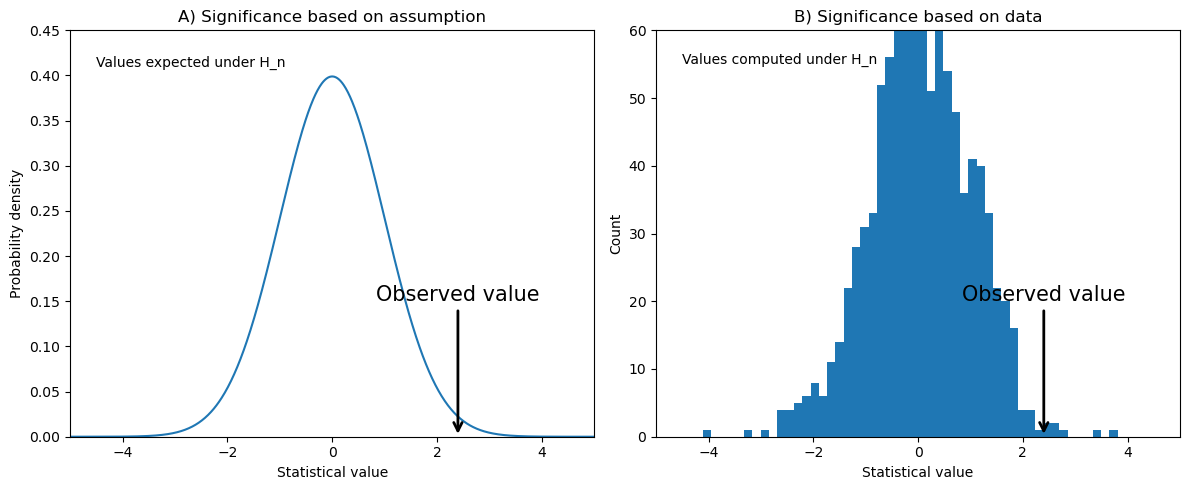

In [4]:
x = np.arange(-5,5, .01)
pdf = stats.norm.pdf(x)
data = np.random.randn(1000)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)

plt.plot(x, pdf)
plt.setp(plt.gca(), 'ylabel', 'Probability density', 'xlabel','Statistical value','xlim', [-5,5], 'ylim', [0,0.45], 'title', 'A) Significance based on assumption')
plt.text(-4.5,0.41, 'Values expected under H_n')
arrow_dict = dict(arrowstyle="->", color="black")

plt.annotate('Observed value',  xy=(2.4, 0), size=15, xytext=(2.4, 0.15),arrowprops=dict(lw=2,facecolor='black', arrowstyle="->"),ha='center')

plt.subplot(1,2,2)
plt.hist(data, bins=50)
plt.setp(plt.gca(), 'ylabel', 'Count', 'xlabel', 'Statistical value','xlim', [-5,5], 'ylim', [0, 60], 'title', 'B) Significance based on data')
plt.text(-4.5,55, 'Values computed under H_n')
plt.annotate('Observed value',  xy=(2.4, 0), size=15, xytext=(2.4, 20),arrowprops=dict(lw=2,facecolor='black', arrowstyle="->"),ha='center')

plt.tight_layout()

## Figure 33.3

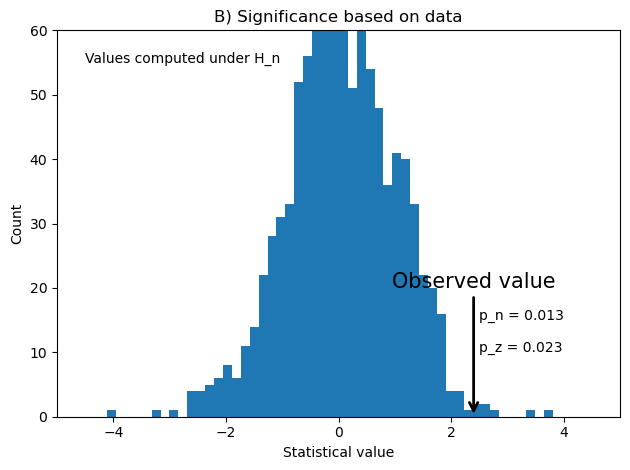

In [5]:
plt.hist(data, bins=50)
plt.setp(plt.gca(), 'ylabel', 'Count', 'xlabel', 'Statistical value','xlim', [-5,5], 'ylim', [0, 60], 'title', 'B) Significance based on data')
plt.text(-4.5,55, 'Values computed under H_n')
plt.annotate('Observed value',  xy=(2.4, 0), size=15, xytext=(2.4, 20),arrowprops=dict(lw=2,facecolor='black', arrowstyle="->"),ha='center')

plt.text(2.5, 15, f'p_n = {sum(data>2)/1000:.3f}')
plt.text(2.5, 10, f'p_z = {1-stats.norm.cdf(2):.3f}')
plt.tight_layout()

## Figure 33.5, 6

In [6]:
# These figures are generated in the code for chapter 34

## Figure 33.8

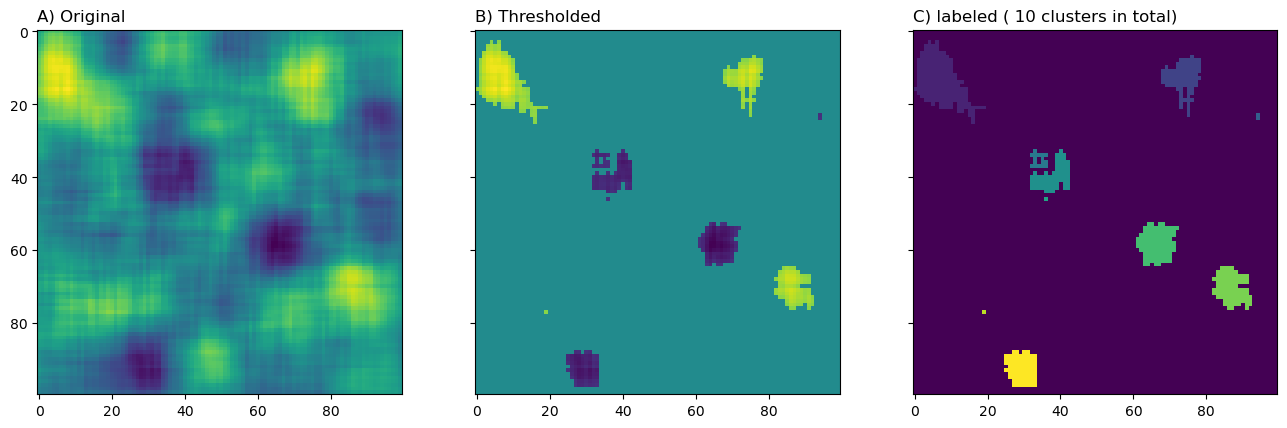

In [7]:
# create 2D smoothing kernel
xi, yi = np.meshgrid(np.arange(-10, 11), np.arange(-10, 11))
zi = xi**2 + yi**2
zi = 1 - (zi/np.max(zi))

# create a random smoothed map
map = sig.convolve2d(np.random.randn(100,100), zi,'same')

# threshold map at an arbitrary value
mapt = map.copy()
mapt[(np.abs(map)<map.flatten().std()*2)] = 0

# Get labeled map via label
mapl, nblobs = ndimage.label(mapt != 0)

# Using scipy's find_objects to find properties of labeled regions
blobinfo = ndimage.find_objects(mapl)
clustcount = np.zeros(nblobs)
clustsum = np.zeros(nblobs)
for i in range(nblobs):
    idx = blobinfo[i]
    clustcount[i] = np.prod([j.stop - j.start for j in idx])
    clustsum[i] = np.sum(map[idx])

# Cluster count can be done faster using list comprehension
clustercount = [np.sum(mapl == i) for i in range(1, nblobs+1)]

# Results
clustcount, clustsum, clustercount

fig, ax = plt.subplots(1,3,figsize=(16,5),sharex='all',sharey='all')
ax[0].imshow(map)
ax[0].set_title('A) Original', loc='left')
ax[1].imshow(mapt)
ax[1].set_title('B) Thresholded', loc='left')
ax[2].imshow(mapl)
_=ax[2].set_title(f'C) labeled ( {len(clustcount)} clusters in total)', loc='left')

## Figure 33.10

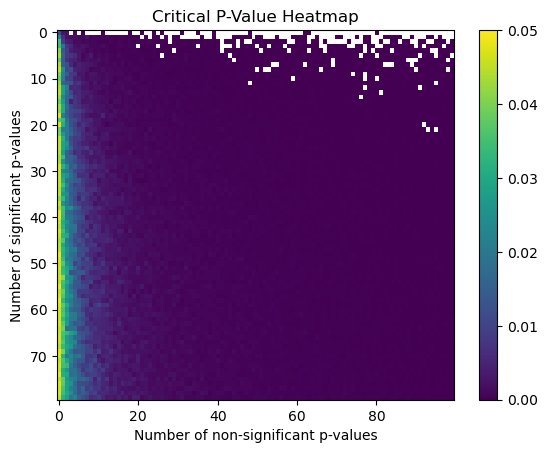

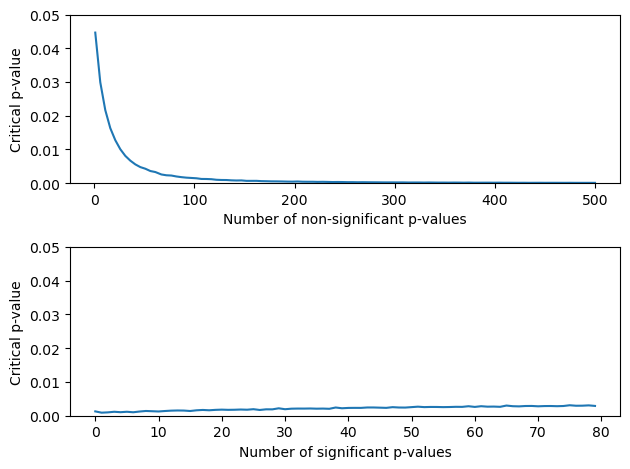

In [8]:
nsigs = np.round(np.linspace(1, 500, 80)).astype(int)
nnons = np.round(np.linspace(1, 500, 100)).astype(int)

fdrpvals = np.zeros((20, len(nsigs), len(nnons)))

for iteri in range(20):
    for i, nsig in enumerate(nsigs):
        for j, nnon in enumerate(nnons):
            pvals = np.concatenate([np.random.rand(nsig) * 0.05, np.random.rand(nnon) * 0.5 + 0.05])
            # replicate the matlab fdr func.
            _, temp = fdrcorrection(pvals, alpha=0.05)
            temp2= pvals[_!=False]
            if temp2.size == 0:
                fdrpvals[iteri, i, j] = np.nan
            else:
                fdrpvals[iteri, i, j] = np.max(temp2)

import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)
fdrpvals_mean = np.nanmean(fdrpvals, axis=0)

plt.figure()
plt.imshow(fdrpvals_mean, aspect='auto')
plt.colorbar()
plt.clim(0, 0.05)
plt.xlabel('Number of non-significant p-values')
plt.ylabel('Number of significant p-values')
plt.title('Critical P-Value Heatmap')

plt.figure()
plt.subplot(211)
plt.plot(nnons, np.nanmean(fdrpvals_mean, axis=0))
plt.xlabel('Number of non-significant p-values')
plt.ylabel('Critical p-value')
plt.ylim(0, 0.05)

plt.subplot(212)
plt.plot(np.nanmean(fdrpvals_mean, axis=1))
plt.xlabel('Number of significant p-values')
plt.ylabel('Critical p-value')
plt.ylim(0, 0.05)

plt.tight_layout()
plt.show()